# Business Problem:

How can Spotify leverage the commonalities among songs posted over the years to optimize song recommendations tailored to users' individual music preferences and listening history?

# Data Preprocessing

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from plotly.express import scatter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import time

In [2]:
import session_info
session_info.show()

In [2]:
# Read in data
df = pd.read_csv("spotify-2023.csv", encoding='latin-1', thousands=',')
df.head()

track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...  bpm  key   mode  \
0                147  141381703                  43  ...  125    B  Major   
1                 48  133716286                  48  ...   92   C#  Major   
2                113  140003974                  94  ...  138    F  Major   
3                100  800840817                 116  ...  170    A  Major   
4                 50  303236322                  84  ...  144    A  Minor   

   danceability_%  valence_% energy_% acousticness_%  instrumentalness_%  \
0              80         89       83             31                   0   
1              71         61       74              7                   0   
2              51         32       53             17                   0   
3              55         58       72             11                   0   
4              65         23       80             14                  63   

   liveness_%  speechiness_%  
0           8              4  
1          10              4  
2          31              6  
3          11             15  
4          11              6  

[5 rows x 24 columns]

In [3]:
# Check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            953 non-null    object 
 1   artist(s)_name        953 non-null    object 
 2   artist_count          953 non-null    int64  
 3   released_year         953 non-null    int64  
 4   released_month        953 non-null    int64  
 5   released_day          953 non-null    int64  
 6   in_spotify_playlists  953 non-null    int64  
 7   in_spotify_charts     953 non-null    int64  
 8   streams               953 non-null    object 
 9   in_apple_playlists    953 non-null    int64  
 10  in_apple_charts       953 non-null    int64  
 11  in_deezer_playlists   953 non-null    int64  
 12  in_deezer_charts      953 non-null    int64  
 13  in_shazam_charts      903 non-null    float64
 14  bpm                   953 non-null    int64  
 15  key                   8

In [4]:
# Check number of null values for each column
df.isnull().sum()

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

In [5]:
# Drop redundant columns since they all represent the popularity of the song in different platforms.
df_new = df.drop(columns=['artist_count','streams','in_apple_playlists', 'in_apple_charts','in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts'])
df_new.head()

track_name    artist(s)_name  released_year  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook           2023   
1                                 LALA       Myke Towers           2023   
2                              vampire    Olivia Rodrigo           2023   
3                         Cruel Summer      Taylor Swift           2019   
4                       WHERE SHE GOES         Bad Bunny           2023   

   released_month  released_day  in_spotify_playlists  in_spotify_charts  bpm  \
0               7            14                   553                147  125   
1               3            23                  1474                 48   92   
2               6            30                  1397                113  138   
3               8            23                  7858                100  170   
4               5            18                  3133                 50  144   

  key   mode  danceability_%  valence_%  energy_%  acousticness_%  \
0   B  Major              80         89        83              31   
1  C#  Major              71         61        74               7   
2   F  Major              51         32        53              17   
3   A  Major              55         58        72              11   
4   A  Minor              65         23        80              14   

   instrumentalness_%  liveness_%  speechiness_%  
0                   0           8              4  
1                   0          10              4  
2                   0          31              6  
3                   0          11             15  
4                  63          11              6

In [6]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   released_year         953 non-null    int64 
 3   released_month        953 non-null    int64 
 4   released_day          953 non-null    int64 
 5   in_spotify_playlists  953 non-null    int64 
 6   in_spotify_charts     953 non-null    int64 
 7   bpm                   953 non-null    int64 
 8   key                   858 non-null    object
 9   mode                  953 non-null    object
 10  danceability_%        953 non-null    int64 
 11  valence_%             953 non-null    int64 
 12  energy_%              953 non-null    int64 
 13  acousticness_%        953 non-null    int64 
 14  instrumentalness_%    953 non-null    int64 
 15  liveness_%            953 non-null    in

In [7]:
# Drop rows with missing data in key
df_new = df_new.dropna()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 858 entries, 0 to 952
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            858 non-null    object
 1   artist(s)_name        858 non-null    object
 2   released_year         858 non-null    int64 
 3   released_month        858 non-null    int64 
 4   released_day          858 non-null    int64 
 5   in_spotify_playlists  858 non-null    int64 
 6   in_spotify_charts     858 non-null    int64 
 7   bpm                   858 non-null    int64 
 8   key                   858 non-null    object
 9   mode                  858 non-null    object
 10  danceability_%        858 non-null    int64 
 11  valence_%             858 non-null    int64 
 12  energy_%              858 non-null    int64 
 13  acousticness_%        858 non-null    int64 
 14  instrumentalness_%    858 non-null    int64 
 15  liveness_%            858 non-null    int64 


In [8]:
# Combine released year, month and day into one column
df_new['released_date']=df_new.apply(lambda x: pd.to_datetime(date(year=x['released_year'], month=x['released_month'], day=x['released_day'])),axis=1)
df_new = df_new.drop(columns=['released_month', 'released_day'])

# assigning value of 1 if the mode is 'Major' and 0 otherwise
# df_new['mode'] = df_new['mode'].apply(lambda x: 1 if x == 'Major' else 0)

# df = df[df['streams'].str.isnumeric()]
# df['streams'] = df['streams'].astype(int)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 858 entries, 0 to 952
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   track_name            858 non-null    object        
 1   artist(s)_name        858 non-null    object        
 2   released_year         858 non-null    int64         
 3   in_spotify_playlists  858 non-null    int64         
 4   in_spotify_charts     858 non-null    int64         
 5   bpm                   858 non-null    int64         
 6   key                   858 non-null    object        
 7   mode                  858 non-null    object        
 8   danceability_%        858 non-null    int64         
 9   valence_%             858 non-null    int64         
 10  energy_%              858 non-null    int64         
 11  acousticness_%        858 non-null    int64         
 12  instrumentalness_%    858 non-null    int64         
 13  liveness_%            858

# EDA

In [9]:
# Number of songs that is least poplular in Spotify charts (in_spotify_charts value is 0)
(df_new['in_spotify_charts'] == 0).sum()

365

In [10]:
# Popularity of songs in spotify charts
print('Minimum popularity:', df_new['in_spotify_charts'].min())
print('Maximum popularity:', df_new['in_spotify_charts'].max())

Minimum popularity: 0
Maximum popularity: 147


In [11]:
# Change the rank to the least importance place in chart, otherwise 0 will represent the most popular one
df_new.loc[df_new['in_spotify_charts'] == 0, 'in_spotify_charts'] = 148

In [12]:
(df_new['in_spotify_charts'] == 148).sum()

365

In [13]:
(df_new['in_spotify_charts'] == 0).sum()

0

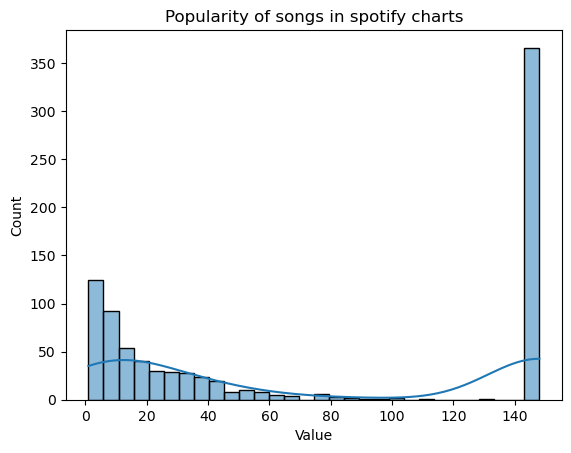

In [14]:
# Plot popularity of songs in spotify charts
sns.histplot(df_new['in_spotify_charts'], bins=30, kde=True)
plt.title('Popularity of songs in spotify charts')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

There are many songs that did not show up in any spotify charts and more songs showed up less frequently in spotify charts than those songs that showed up more frequently

In [15]:
# Number of songs that is not poplular in Spotify playlists (in_spotify_charts value is 0)
(df_new['in_spotify_playlists'] == 0).sum()

0

In [16]:
# Popularity of songs in spotify playlists
print('Minimum popularity:', df_new['in_spotify_playlists'].min())
print('Maximum popularity:', df_new['in_spotify_playlists'].max())

Minimum popularity: 31
Maximum popularity: 52898


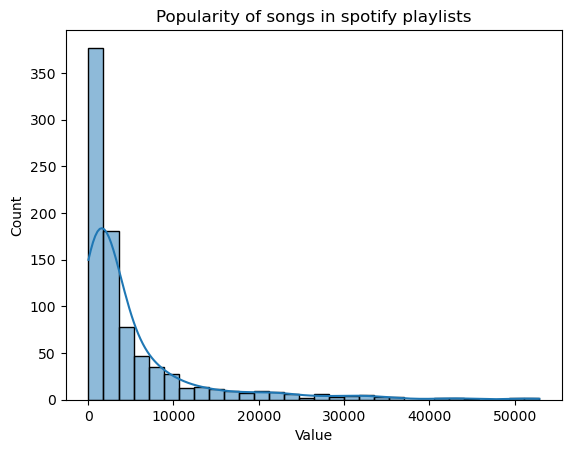

In [17]:
# Plot popularity of songs in spotify playlists
sns.histplot(df_new['in_spotify_playlists'], bins=30, kde=True)
plt.title('Popularity of songs in spotify playlists')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

All songs showed up at least once in spotify playlists, but more songs showed up less frequently in spotify charts than those songs that showed up more frequently

In [18]:
# Number of artists in the dataset
df_new['artist(s)_name'].nunique()

597

In [19]:
# Top 10 artists 
df_new.groupby('artist(s)_name')['track_name'].count().reset_index().sort_values(by='track_name', ascending=False).head(12)

artist(s)_name  track_name
514      Taylor Swift          29
528        The Weeknd          17
459               SZA          17
39          Bad Bunny          16
203      Harry Styles          13
272    Kendrick Lamar          12
147        Ed Sheeran           9
368     Morgan Wallen           9
36                BTS           8
164              Feid           8
400    Olivia Rodrigo           7
131  Drake, 21 Savage           7

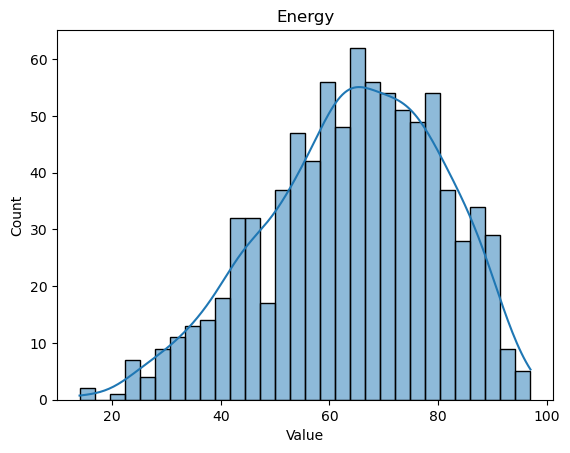

In [20]:
# Plot popularity of songs in spotify playlists
sns.histplot(df_new['energy_%'], bins=30, kde=True)
plt.title('Energy')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

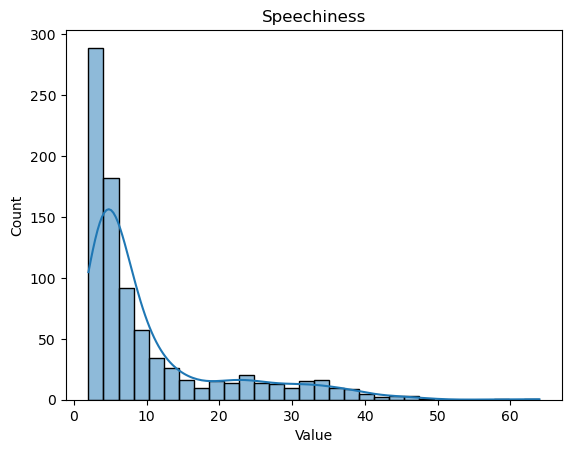

In [21]:
# Plot popularity of songs in spotify playlists
sns.histplot(df_new['speechiness_%'], bins=30, kde=True)
plt.title('Speechiness')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

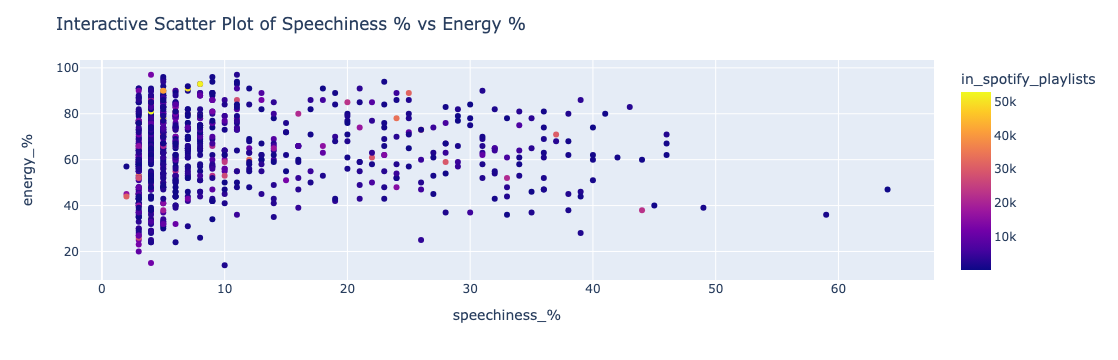

In [22]:
import plotly.express as px
fig = px.scatter(df_new, x='speechiness_%', y='energy_%', color='in_spotify_playlists', hover_name='track_name')
fig.update_layout(title="Interactive Scatter Plot of Speechiness % vs Energy %")
fig.show()

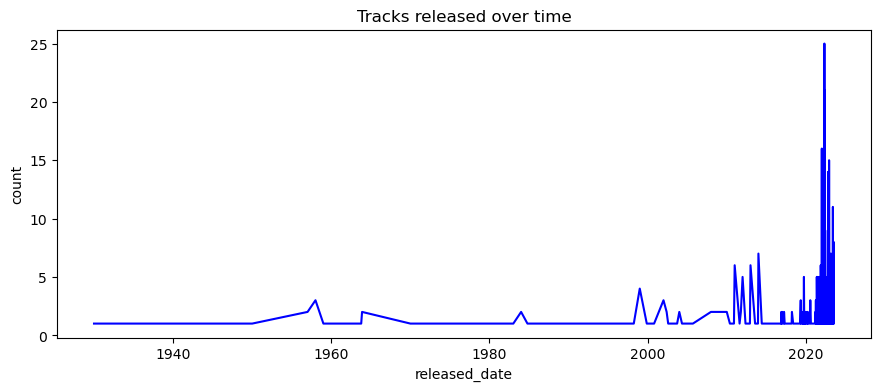

In [23]:
# Number of songs released over time
plt.figure(figsize=(10.5, 4))
count_per_time = df_new['released_date'].value_counts().reset_index()
sns.lineplot(data=count_per_time, x='released_date', y='count', color='blue').set(title='Tracks released over time')
plt.show()

We can tell that are signifiant more songs released after 2010 and after 2018

In [24]:
# Define categorical and numerical columns
cat_col = df_new.select_dtypes(include=['object']).columns
num_col = df_new.select_dtypes(exclude=['object']).columns.drop(['released_date'])
print(cat_col)
print(num_col)

Index(['track_name', 'artist(s)_name', 'key', 'mode'], dtype='object')
Index(['released_year', 'in_spotify_playlists', 'in_spotify_charts', 'bpm',
       'danceability_%', 'valence_%', 'energy_%', 'acousticness_%',
       'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')


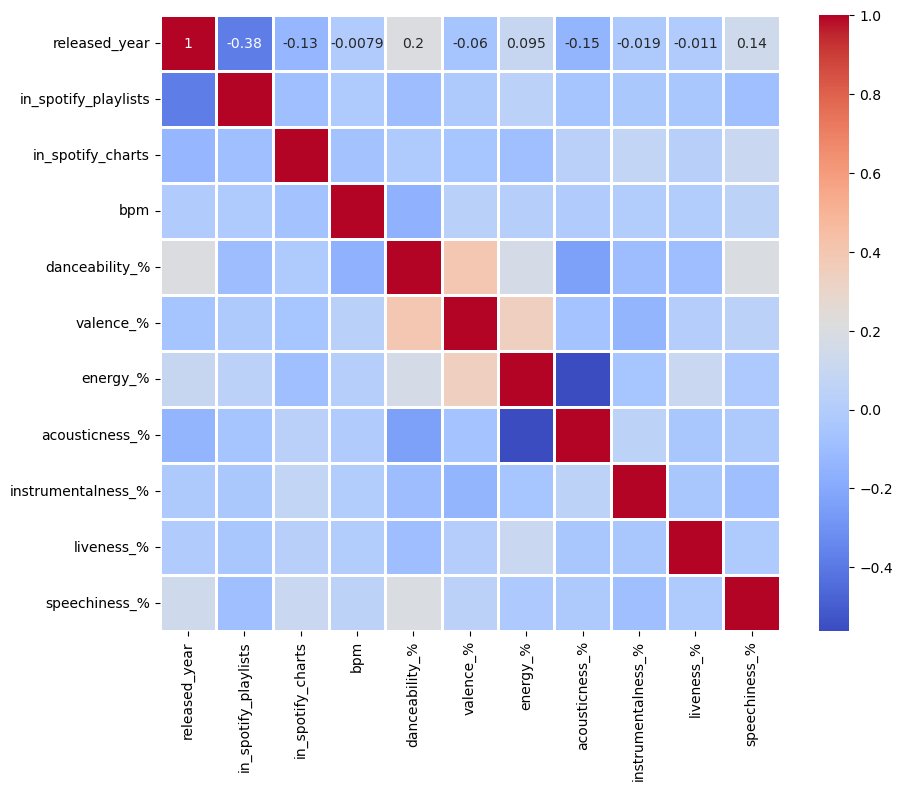

In [25]:
# Heatmap for Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_new[num_col].corr(), annot=True, cmap='coolwarm', linewidths=2)
plt.show()

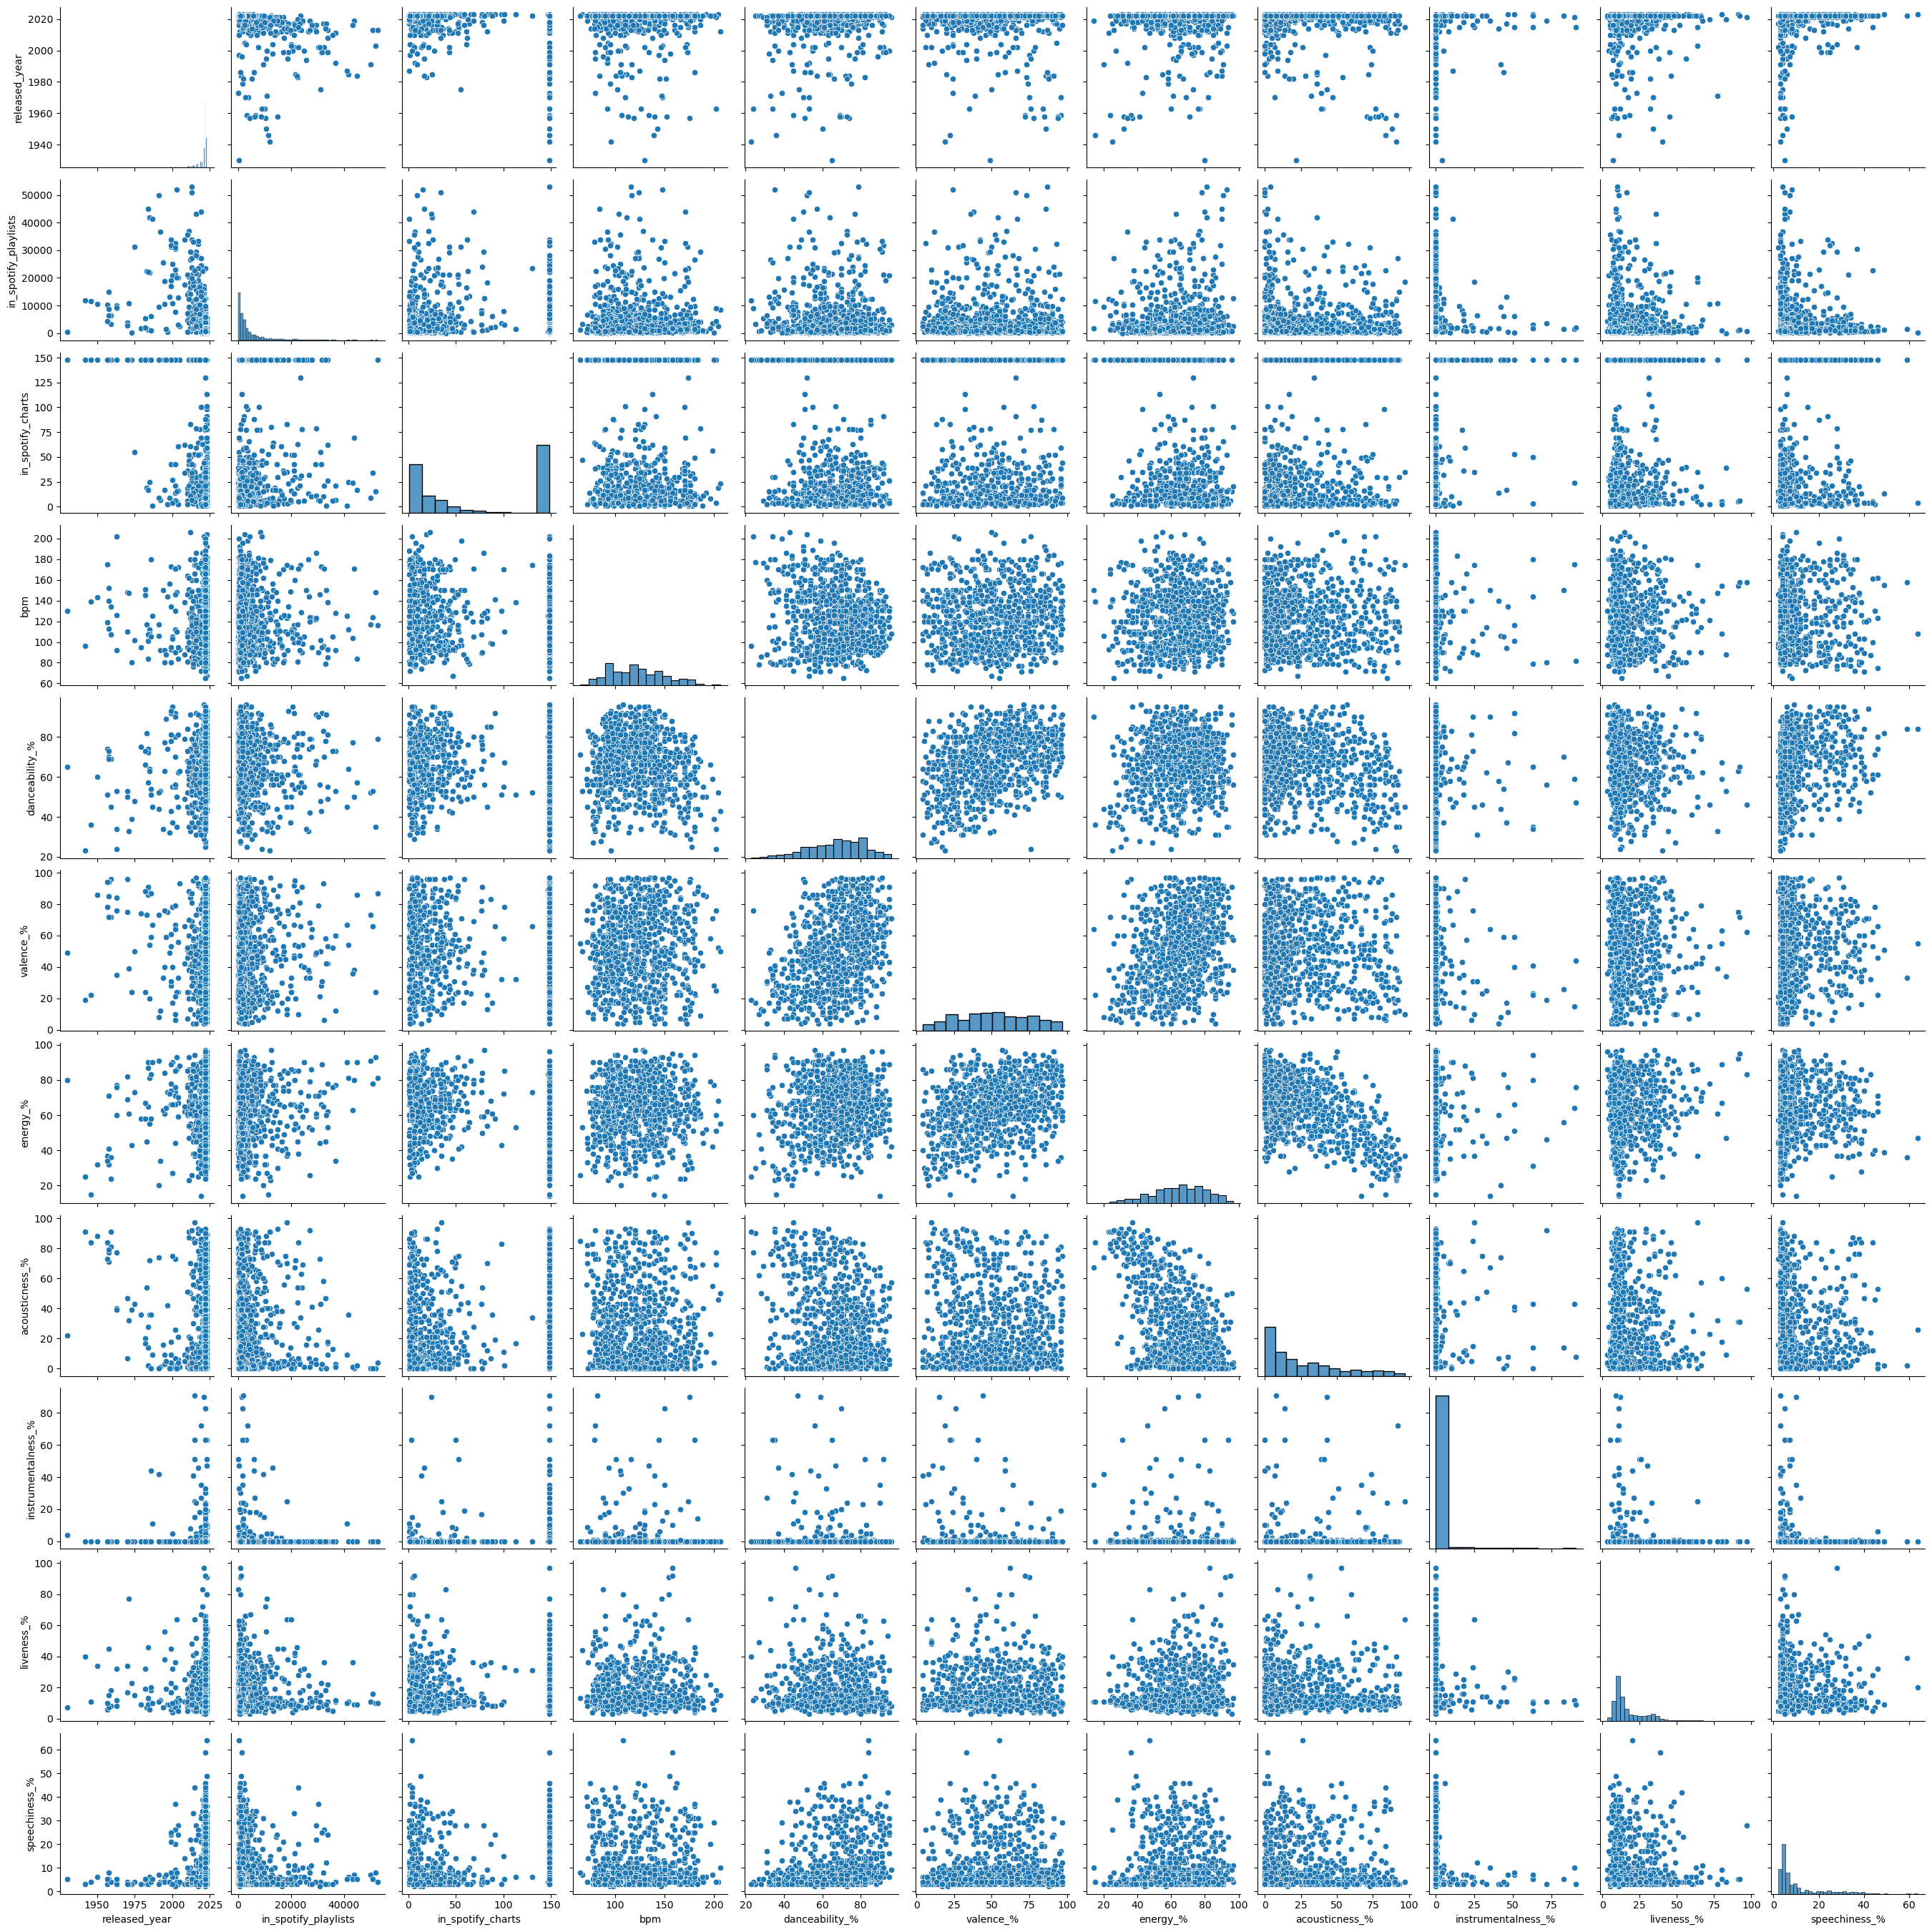

In [26]:
# Pairwise plot
sns.pairplot(df_new[num_col], palette='Set2')

<Axes: >

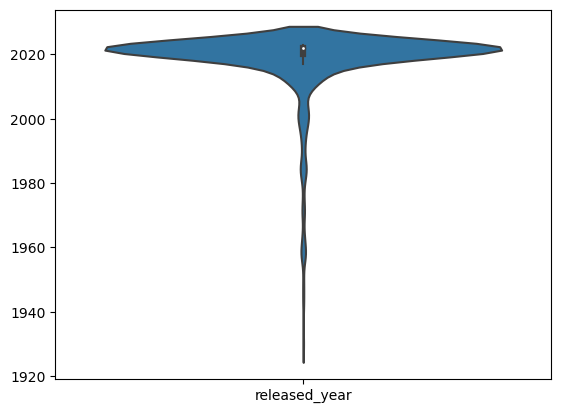

In [27]:
# Distribution Plot for each numeric column
sns.violinplot(data = df_new[num_col].iloc[:,0:1])

<Axes: >

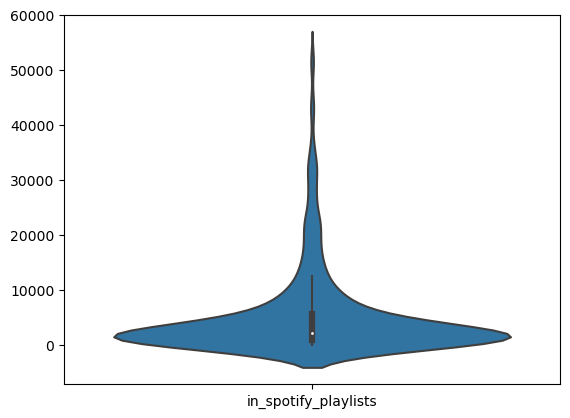

In [28]:
sns.violinplot(data = df_new[num_col].iloc[:,1:2])

<Axes: >

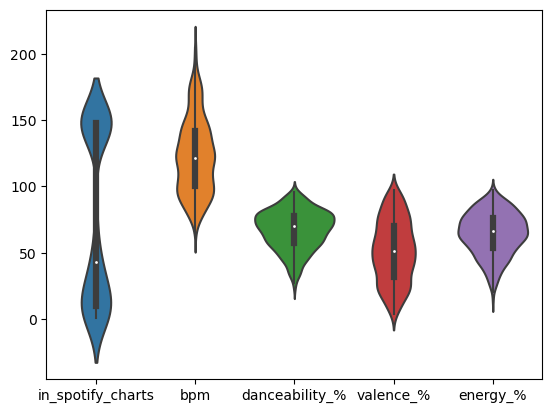

In [29]:
sns.violinplot(data = df_new[num_col].iloc[:,2:7])

<Axes: >

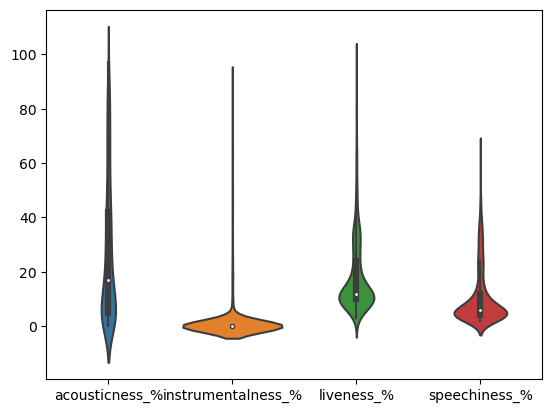

In [30]:
sns.violinplot(data = df_new[num_col].iloc[:,7:])

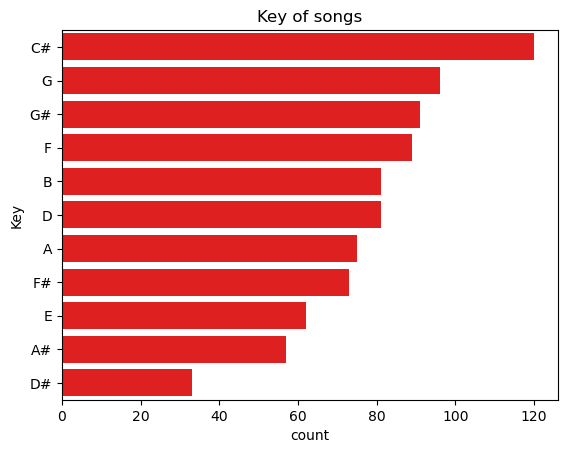

In [31]:
# Distribution Plot for Key
sns.countplot(data=df_new, y='key',color='red', order=df['key'].value_counts().index).set(title='Key of songs', ylabel='Key')
plt.show()

Most songs have C# Key

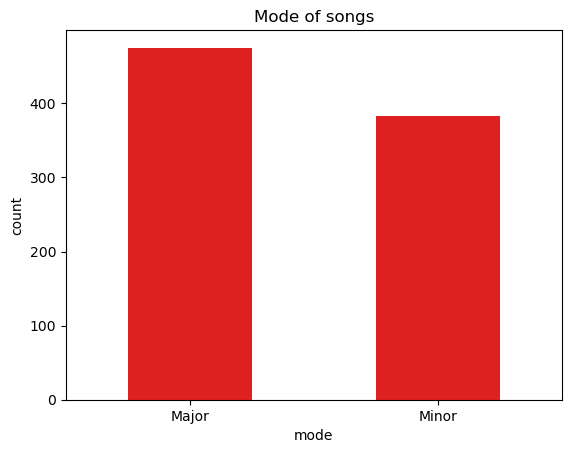

In [32]:
# Distribution Plot for mode
sns.countplot(data=df_new, x='mode', color='red', width=.5).set(title='Mode of songs')
plt.show()

Major mode song and minor mode songs have pretty similar size but there are more major mode songs

# Dimensionality Reduction

In [33]:
# Normalize all numerical varaiables
df_org = df_new.copy()
scaler = StandardScaler()
df_new[num_col] = scaler.fit_transform(df_new[num_col])
df_new.head()

track_name    artist(s)_name  released_year  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook       0.428665   
1                                 LALA       Myke Towers       0.428665   
2                              vampire    Olivia Rodrigo       0.428665   
3                         Cruel Summer      Taylor Swift       0.068347   
4                       WHERE SHE GOES         Bad Bunny       0.428665   

   in_spotify_playlists  in_spotify_charts       bpm key   mode  \
0             -0.585909           1.110104  0.077129   B  Major   
1             -0.469843          -0.414290 -1.094451  C#  Major   
2             -0.479547           0.586575  0.538660   F  Major   
3              0.334677           0.386402  1.674738   A  Major   
4             -0.260774          -0.383494  0.751675   A  Minor   

   danceability_%  valence_%  energy_%  acousticness_%  instrumentalness_%  \
0        0.870216   1.600987  1.163146        0.170601           -0.188012   
1        0.255637   0.413592  0.601993       -0.764456           -0.188012   
2       -1.110094  -0.816211 -0.707364       -0.374849           -0.188012   
3       -0.836948   0.286371  0.477292       -0.608613           -0.188012   
4       -0.154082  -1.197873  0.976095       -0.491731            7.171014   

   liveness_%  speechiness_% released_date  
0   -0.750618      -0.633598    2023-07-14  
1   -0.603057      -0.633598    2023-03-23  
2    0.946335      -0.435230    2023-06-30  
3   -0.529277       0.457425    2019-08-23  
4   -0.529277      -0.435230    2023-05-18

In [34]:
df_new.describe()

released_year  in_spotify_playlists  in_spotify_charts           bpm  \
count   8.580000e+02          8.580000e+02       8.580000e+02  8.580000e+02   
mean    7.155116e-15         -2.070346e-17       1.325021e-16 -1.407835e-16   
min    -7.948728e+00         -6.516920e-01      -1.137993e+00 -2.053016e+00   
25%     1.584265e-01         -5.471888e-01      -9.994113e-01 -8.104317e-01   
50%     3.385855e-01         -3.750752e-01      -4.912799e-01 -6.488088e-02   
75%     3.385855e-01          4.120463e-02       1.125502e+00  6.717943e-01   
max     4.286650e-01          6.010676e+00       1.125502e+00  2.952825e+00   
std     1.000583e+00          1.000583e+00       1.000583e+00  1.000583e+00   

       danceability_%     valence_%      energy_%  acousticness_%  \
count    8.580000e+02  8.580000e+02  8.580000e+02    8.580000e+02   
mean    -4.202802e-16  1.242208e-16 -4.099285e-16   -1.242208e-17   
min     -3.022118e+00 -2.003606e+00 -3.139026e+00   -1.037180e+00   
25%     -7.003749e-01 -8.162107e-01 -6.917760e-01   -8.423770e-01   
50%      1.873503e-01 -1.047818e-02  1.031905e-01   -3.748489e-01   
75%      7.336428e-01  7.952543e-01  7.266937e-01    5.991680e-01   
max      1.962801e+00  1.940243e+00  2.036050e+00    2.742005e+00   
std      1.000583e+00  1.000583e+00  1.000583e+00    1.000583e+00   

       instrumentalness_%    liveness_%  speechiness_%  \
count        8.580000e+02  8.580000e+02     858.000000   
mean         4.140692e-18 -5.382900e-17       0.000000   
min         -1.880123e-01 -1.119521e+00      -0.831966   
25%         -1.880123e-01 -6.030572e-01      -0.633598   
50%         -1.880123e-01 -4.554961e-01      -0.435230   
75%         -1.880123e-01  4.298706e-01       0.159873   
max          1.044169e+01  5.815851e+00       5.317436   
std          1.000583e+00  1.000583e+00       1.000583   

                       released_date  
count                            858  
mean   2018-09-10 21:10:29.370629120  
min              1930-01-01 00:00:00  
25%              2020-06-10 18:00:00  
50%              2022-04-08 00:00:00  
75%              2022-11-04 00:00:00  
max              2023-07-14 00:00:00  
std                              NaN

T-SNE for song mode (1 represents 'Major', 0 represents 'Minor'):

## tSNE

T-SNE for song mode:

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 858 samples in 0.001s...
[t-SNE] Computed neighbors for 858 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 858 / 858
[t-SNE] Mean sigma: 1.032352
[t-SNE] KL divergence after 200 iterations with early exaggeration: 67.973419
[t-SNE] KL divergence after 1000 iterations: 1.060900
KL Divergence:  1.0609002113342285
Number of iterations:  999


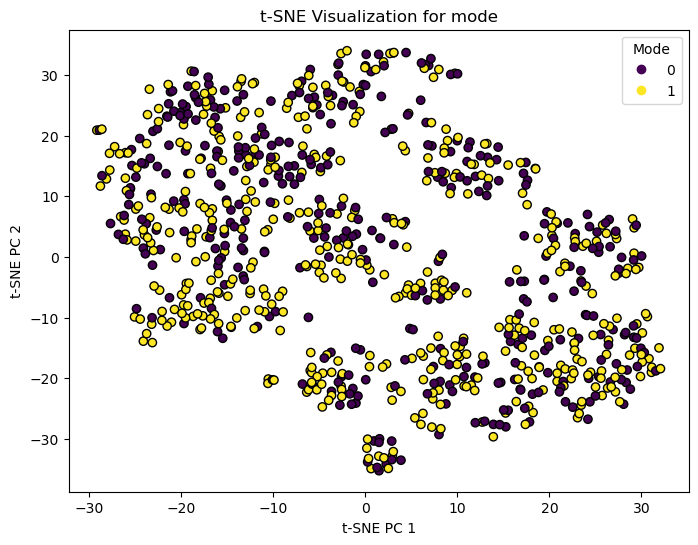

In [35]:
# Perform tSNE dimensionality reduction
tsne =  TSNE(n_components=2, verbose=1, random_state=42)
X_tsne = tsne.fit_transform(X=df_new[num_col])

# Print intermediate values
print("KL Divergence: ", tsne.kl_divergence_)
print("Number of iterations: ", tsne.n_iter_)

# Visualize tSNE result for mode
plt.figure(figsize=(8, 6))
color = df_new['mode'].apply(lambda x: 1 if x == 'Major' else 0)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap='viridis', edgecolor='k')
plt.title('t-SNE Visualization for mode')
plt.xlabel('t-SNE PC 1')
plt.ylabel('t-SNE PC 2')
plt.legend(*scatter.legend_elements(), title='Mode')
plt.show()

T-SNE for song released year:

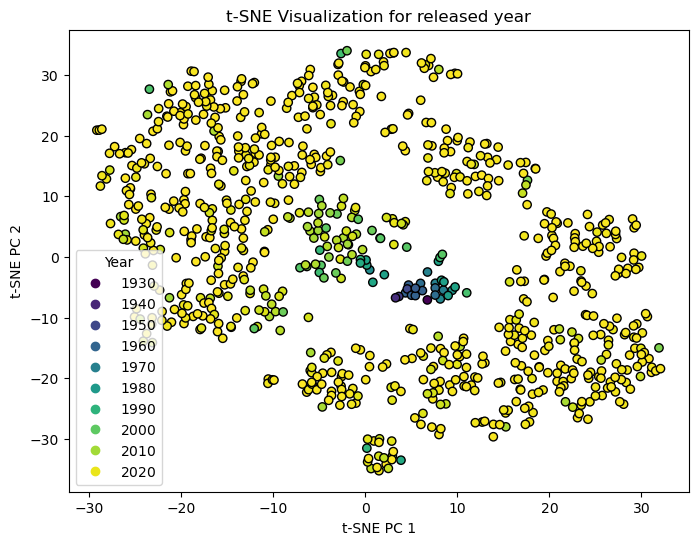

In [36]:
# Visualize tSNE result for released year
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_org['released_year'], cmap='viridis', edgecolor='k')
plt.title('t-SNE Visualization for released year')
plt.xlabel('t-SNE PC 1')
plt.ylabel('t-SNE PC 2')
plt.legend(*scatter.legend_elements(), title='Year')
plt.show()

T-SNE for song key:

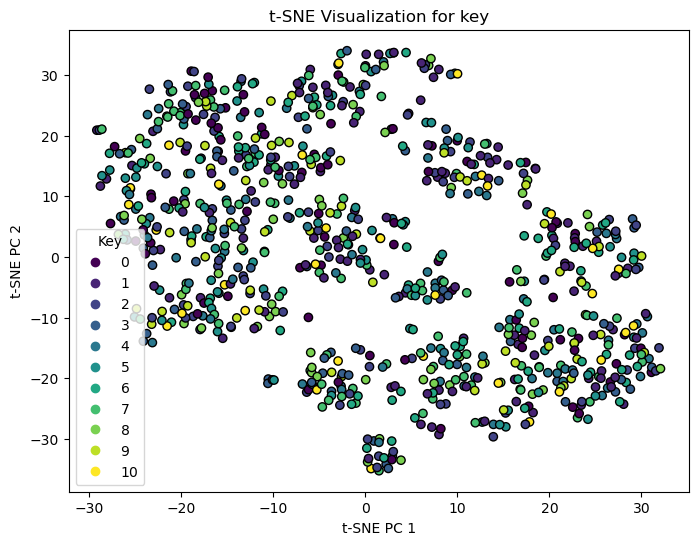

In [37]:
# Visualize tSNE result for key
plt.figure(figsize=(8, 6))
unique_keys = df_org['key'].unique()
key_to_color = {key: i for i, key in enumerate(unique_keys)}
color = df_org['key'].map(key_to_color)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap='viridis', edgecolor='k')
plt.title('t-SNE Visualization for key')
plt.xlabel('t-SNE PC 1')
plt.ylabel('t-SNE PC 2')
plt.legend(*scatter.legend_elements(), title='Key')
plt.show()

## PCA

PCA for song mode:

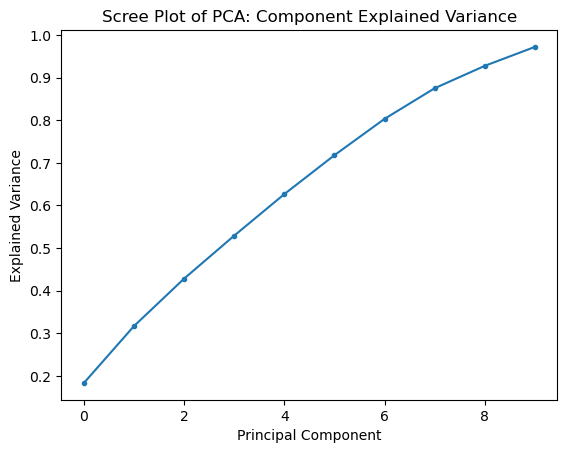

In [38]:
# Choose the best number of components for PCA
pca = PCA(n_components=10)
pca_fit = pca.fit_transform(df_new[num_col])
df_pca = pd.DataFrame(data = pca_fit
             , columns = ['PC '+ str(i+1) for i in range(10)])
ax = plt.figure().gca()
ax.plot(np.cumsum(pca.explained_variance_ratio_), marker='.')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Scree Plot of PCA: Component Explained Variance')
plt.show()

Since the vairance is increasing almost linearly over the first 7 components, we're choosing to use 2 PC's because of the ease of visualization with 2 components and the interpretability of the loadings. Specifically, we considered the loadings for a variety of PC's and found the most meaning concentrating on the top two.

PCA for song mode:

Text(0.5, 1.0, 'PCA Visualization for mode')

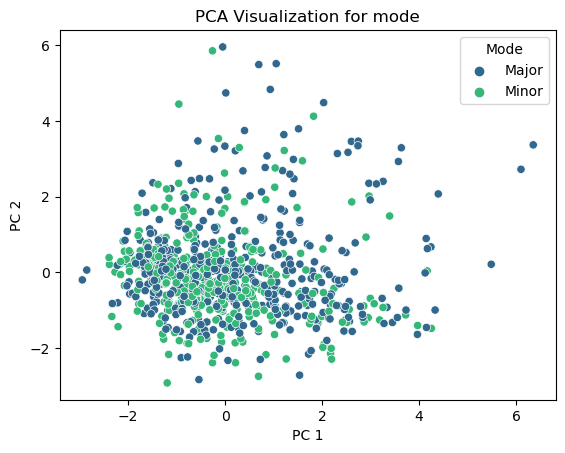

In [39]:
# Perform PCA dimensionality reduction
n_comp = 2
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(X=df_new[num_col])
X_pca = pd.DataFrame(data = X_pca, columns=['PC '+ str(i+1) for i in range(n_comp)])
X_pca['Mode'] = df_new['mode'].values

# Visualize PCA result for mode
sns.scatterplot(data=X_pca, x='PC 1', y='PC 2', hue='Mode', palette='viridis')
plt.title('PCA Visualization for mode')

PCA for song released year:

Text(0.5, 1.0, 'PCA Visualization for Released year')

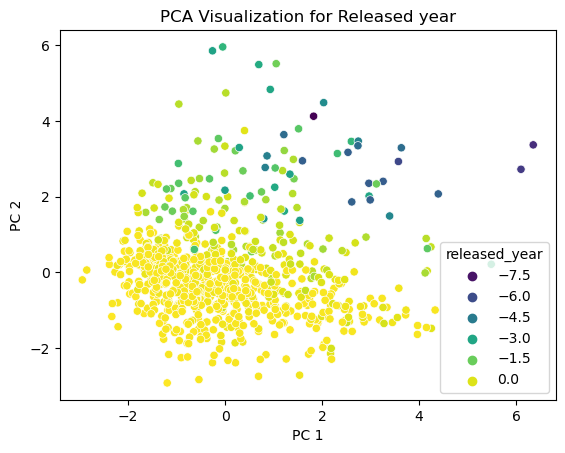

In [40]:
# Visualize PCA result for released year
X_pca['released_year'] = df_new['released_year'].values
sns.scatterplot(data=X_pca, x='PC 1', y='PC 2', hue='released_year', palette='viridis')
plt.title('PCA Visualization for Released year')

PCA for song key:

Text(0.5, 1.0, 'PCA Visualization for key')

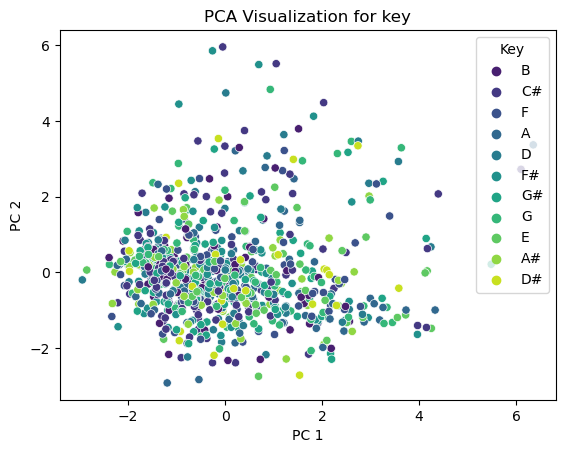

In [41]:
# Visualize PCA result for keyPCA for song released year:
X_pca['Key'] = df_new['key'].values
sns.scatterplot(data=X_pca, x='PC 1', y='PC 2', hue='Key', palette='viridis')
plt.title('PCA Visualization for key')

In [42]:
pca.explained_variance_ratio_.sum()

0.31692326854763764

In [74]:
loadings = pca.components_
results = pd.DataFrame(loadings.transpose())
results.columns = ['Component 1', 'Component 2']
results.index = ['released_year', 'in_spotify_playlists', 'in_spotify_charts', 'bpm',
       'danceability_%', 'valence_%', 'energy_%', 'acousticness_%',
       'instrumentalness_%', 'liveness_%', 'speechiness_%']
print(results)

                      Component 1  Component 2
released_year           -0.260289    -0.523572
in_spotify_playlists     0.107906     0.599054
in_spotify_charts        0.108565    -0.137120
bpm                      0.034223     0.059526
danceability_%          -0.463341    -0.190716
valence_%               -0.407372     0.143267
energy_%                -0.508831     0.315087
acousticness_%           0.463723    -0.218230
instrumentalness_%       0.172079    -0.039959
liveness_%              -0.038403     0.088803
speechiness_%           -0.148249    -0.362459


# Clustering

## K-Prototype

In [43]:
# Data preparation: 
# We would not use artist name or track name to cluster songs since 
# artists rarely have more than one songs in this dataset
# and track name just represents the name of each song
X_df = X_pca.drop(columns=['released_year'])
X_df['Mode'] = X_df['Mode'].astype('category')
X_df['Key'] = X_df['Key'].astype('category')
print(X_df)
X = X_df.to_numpy()
categorical_indices = [X_df.columns.get_loc(col) for col in ['Mode', 'Key']]

         PC 1      PC 2   Mode Key
0   -1.529375 -0.159879  Major   B
1   -1.107713  0.036380  Major  C#
2    0.947576 -0.357075  Major   F
3   -0.216209  0.489979  Major   A
4    0.997878 -0.186483  Minor   A
..        ...       ...    ...  ..
853  2.160347 -1.228443  Major   A
854  3.963647 -1.635734  Major  F#
855 -1.415479 -0.388330  Major  C#
856 -1.462290 -0.207868  Major  C#
857 -0.006538 -0.156697  Minor   E

[858 rows x 4 columns]


In [44]:
# Choose the best number of clusters
n_clusters_range = range(2, 10)

best_score = -1
best_n_clusters = 0
best_model = None
silhouette_scores = []

for n_cluster in n_clusters_range:
    kproto = KPrototypes(n_clusters=n_cluster, verbose=0, random_state=42)
    clusters = kproto.fit_predict(X, categorical=categorical_indices)
    score = silhouette_score(X_df[['PC 1','PC 2']].to_numpy(), clusters)
    
    silhouette_scores.append(score)
    print(f'Number of clusters: {n_cluster}, Silhouette Score: {score}')
    
    if score > best_score:
        best_score = score
        best_n_clusters = n_cluster
        best_model = kproto

print(f'Best number of clusters: {best_n_clusters}, Best Silhouette Score: {best_score}')

Number of clusters: 2, Silhouette Score: 0.43378744025914856
Number of clusters: 3, Silhouette Score: 0.4469128953463224
Number of clusters: 4, Silhouette Score: 0.3118650769867886
Number of clusters: 5, Silhouette Score: 0.3002380994320732
Number of clusters: 6, Silhouette Score: 0.32071333593559
Number of clusters: 7, Silhouette Score: 0.21883712195150387
Number of clusters: 8, Silhouette Score: 0.19285844764631252
Number of clusters: 9, Silhouette Score: 0.1958798122040757
Best number of clusters: 3, Best Silhouette Score: 0.4469128953463224


In [45]:
# K-Prototype
kproto = KPrototypes(n_clusters=3, verbose=0, random_state=42)
clusters = kproto.fit_predict(X, categorical=categorical_indices)
X_df['Cluster'] = clusters
print(X_df)
score = silhouette_score(X_df[['PC 1','PC 2']].to_numpy(), clusters)
print(score)

         PC 1      PC 2   Mode Key  Cluster
0   -1.529375 -0.159879  Major   B        1
1   -1.107713  0.036380  Major  C#        1
2    0.947576 -0.357075  Major   F        0
3   -0.216209  0.489979  Major   A        1
4    0.997878 -0.186483  Minor   A        0
..        ...       ...    ...  ..      ...
853  2.160347 -1.228443  Major   A        0
854  3.963647 -1.635734  Major  F#        0
855 -1.415479 -0.388330  Major  C#        1
856 -1.462290 -0.207868  Major  C#        1
857 -0.006538 -0.156697  Minor   E        1

[858 rows x 5 columns]
0.4469128953463224


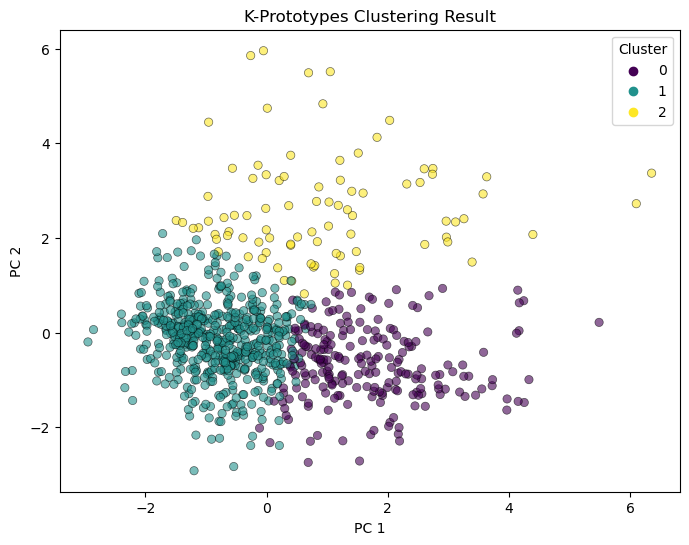

In [46]:
# Visualize the clustering result
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_df, x='PC 1', y='PC 2', hue='Cluster', palette='viridis', edgecolor='k', alpha=0.6)
plt.title('K-Prototypes Clustering Result')
plt.show()

## K-Means

In [47]:
X_df = X_pca.drop(columns=['released_year', 'Mode', 'Key'])
print(X_df)

         PC 1      PC 2
0   -1.529375 -0.159879
1   -1.107713  0.036380
2    0.947576 -0.357075
3   -0.216209  0.489979
4    0.997878 -0.186483
..        ...       ...
853  2.160347 -1.228443
854  3.963647 -1.635734
855 -1.415479 -0.388330
856 -1.462290 -0.207868
857 -0.006538 -0.156697

[858 rows x 2 columns]


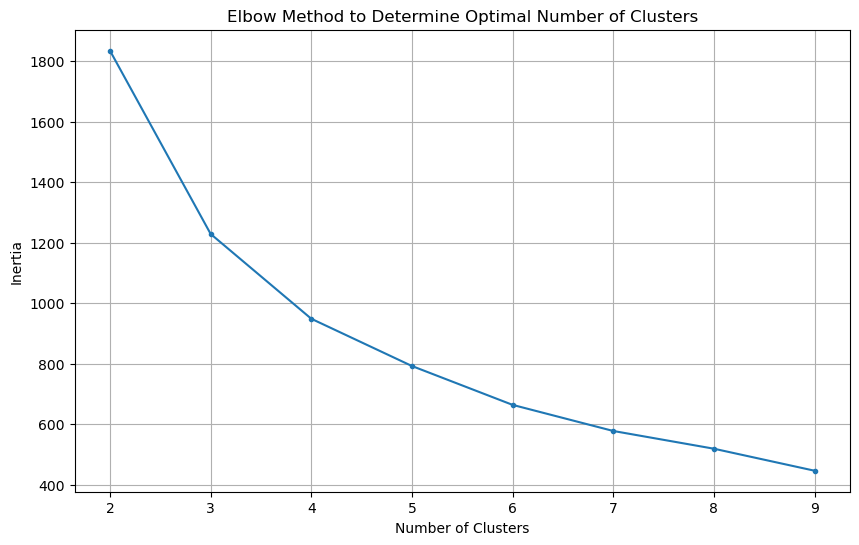

In [48]:
# Using the "Elbow" method
inertia_values = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, init = 'k-means++', max_iter = 300, n_init = 10)
    kmeans.fit(X_df)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values to find the "elbow"
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='.')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.grid(True)
plt.show()

In [49]:
# Initialize variables to store the maximum silhouette score and the corresponding number of clusters
max_silhouette_score = -1
optimal_num_clusters = -1

# Define the range of clusters you want to try
min_clusters = 2
max_clusters = 10  # Adjust this range as needed

for num_clusters in range(min_clusters, max_clusters + 1):
    # Train k-Means with current number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, verbose=False, n_init=10, max_iter=300)
    clusters = kmeans.fit_predict(X_df)
    
    # Compute the Silhouette Score
    silhouette_avg = silhouette_score(X_df, clusters)
    
    # Check if current silhouette score is higher than the maximum seen so far
    if silhouette_avg > max_silhouette_score:
        max_silhouette_score = silhouette_avg
        optimal_num_clusters = num_clusters

print("Optimal number of clusters:", optimal_num_clusters)
print("Maximum Silhouette Score:", max_silhouette_score)

Optimal number of clusters: 3
Maximum Silhouette Score: 0.44980529888100124


In [50]:
# K-Means
kmeans = KMeans(n_clusters=3, random_state=42, verbose=False, n_init=10, max_iter=300)
clusters = kmeans.fit_predict(X_df)
X_df['Cluster'] = clusters
print(X_df)

         PC 1      PC 2  Cluster
0   -1.529375 -0.159879        0
1   -1.107713  0.036380        0
2    0.947576 -0.357075        1
3   -0.216209  0.489979        0
4    0.997878 -0.186483        1
..        ...       ...      ...
853  2.160347 -1.228443        1
854  3.963647 -1.635734        1
855 -1.415479 -0.388330        0
856 -1.462290 -0.207868        0
857 -0.006538 -0.156697        0

[858 rows x 3 columns]


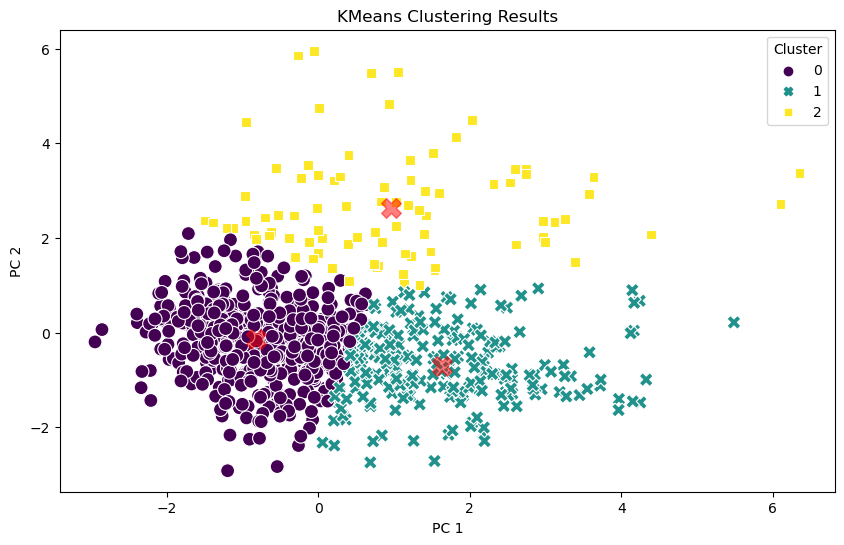

In [51]:
# Visualize the clustering result
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_df, x='PC 1', y='PC 2', hue='Cluster', palette='viridis', style='Cluster', s=100)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='X')
plt.title('KMeans Clustering Results')
plt.show()

## DBScan

In [52]:
X_df = X_pca.drop(columns=['released_year', 'Mode', 'Key'])
print(X_df)

         PC 1      PC 2
0   -1.529375 -0.159879
1   -1.107713  0.036380
2    0.947576 -0.357075
3   -0.216209  0.489979
4    0.997878 -0.186483
..        ...       ...
853  2.160347 -1.228443
854  3.963647 -1.635734
855 -1.415479 -0.388330
856 -1.462290 -0.207868
857 -0.006538 -0.156697

[858 rows x 2 columns]


In [53]:
# Choose the best parameters
eps_values = np.arange(1, 2, 3)
min_samples_values = range(10, 101, 10)

best_score = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_df)
        labels = dbscan.labels_
        
        # Only compute silhouette score if there is more than one cluster present (excluding noise)
        if len(set(labels)) > 1:
            score = silhouette_score(X_df, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best silhouette score: {best_score}")

Best eps: 1, Best min_samples: 10, Best silhouette score: 0.5718926677709238


In [54]:
# Perform DBScan
dbscan = DBSCAN(eps=1, min_samples=10).fit(X_df)
X_df['Cluster'] = dbscan.labels_

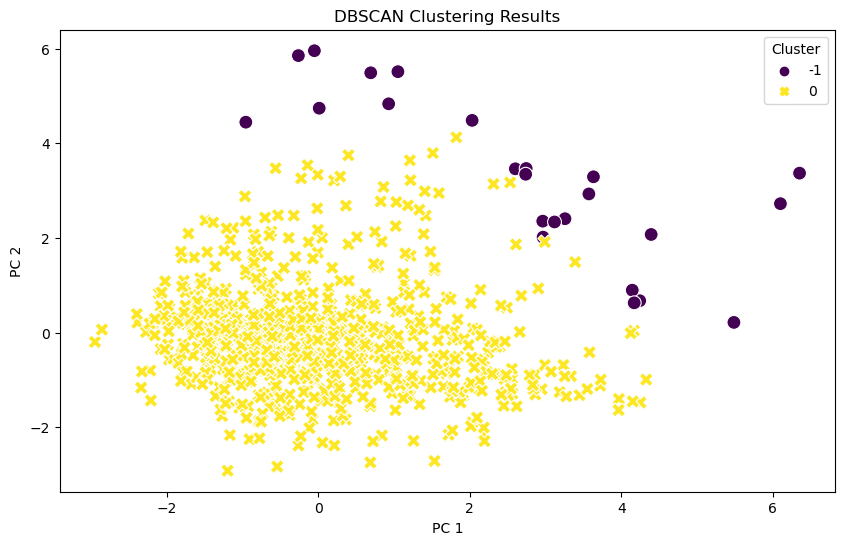

In [55]:
# Visualize the clustering result
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_df, x='PC 1', y='PC 2', hue='Cluster', palette='viridis', style='Cluster', s=100)

# Enhancing the plot
plt.title('DBSCAN Clustering Results')
plt.legend(title='Cluster', loc='upper right')

# Recommendation System

### Based on K-Prototype

In [56]:
KProto_recom = X_pca.copy()
KProto_recom

PC 1      PC 2   Mode  released_year Key
0   -1.529375 -0.159879  Major       0.428665   B
1   -1.107713  0.036380  Major       0.428665  C#
2    0.947576 -0.357075  Major       0.428665   F
3   -0.216209  0.489979  Major       0.068347   A
4    0.997878 -0.186483  Minor       0.428665   A
..        ...       ...    ...            ...  ..
853  2.160347 -1.228443  Major       0.338585   A
854  3.963647 -1.635734  Major       0.338585  F#
855 -1.415479 -0.388330  Major       0.338585  C#
856 -1.462290 -0.207868  Major       0.338585  C#
857 -0.006538 -0.156697  Minor       0.338585   E

[858 rows x 5 columns]

In [57]:
KProto_recom['Cluster_K-Prototype'] = kproto.labels_
KProto_recom

PC 1      PC 2   Mode  released_year Key  Cluster_K-Prototype
0   -1.529375 -0.159879  Major       0.428665   B                    1
1   -1.107713  0.036380  Major       0.428665  C#                    1
2    0.947576 -0.357075  Major       0.428665   F                    0
3   -0.216209  0.489979  Major       0.068347   A                    1
4    0.997878 -0.186483  Minor       0.428665   A                    0
..        ...       ...    ...            ...  ..                  ...
853  2.160347 -1.228443  Major       0.338585   A                    0
854  3.963647 -1.635734  Major       0.338585  F#                    0
855 -1.415479 -0.388330  Major       0.338585  C#                    1
856 -1.462290 -0.207868  Major       0.338585  C#                    1
857 -0.006538 -0.156697  Minor       0.338585   E                    1

[858 rows x 6 columns]

In [58]:
KProto_recom["track_name"] = list(df_new["track_name"])
KProto_recom["artist(s)_name"] = list(df_new["artist(s)_name"])
KProto_recom["in_spotify_charts"] = list(df_new["in_spotify_charts"])
KProto_recom

PC 1      PC 2   Mode  released_year Key  Cluster_K-Prototype  \
0   -1.529375 -0.159879  Major       0.428665   B                    1   
1   -1.107713  0.036380  Major       0.428665  C#                    1   
2    0.947576 -0.357075  Major       0.428665   F                    0   
3   -0.216209  0.489979  Major       0.068347   A                    1   
4    0.997878 -0.186483  Minor       0.428665   A                    0   
..        ...       ...    ...            ...  ..                  ...   
853  2.160347 -1.228443  Major       0.338585   A                    0   
854  3.963647 -1.635734  Major       0.338585  F#                    0   
855 -1.415479 -0.388330  Major       0.338585  C#                    1   
856 -1.462290 -0.207868  Major       0.338585  C#                    1   
857 -0.006538 -0.156697  Minor       0.338585   E                    1   

                              track_name      artist(s)_name  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook   
1                                   LALA         Myke Towers   
2                                vampire      Olivia Rodrigo   
3                           Cruel Summer        Taylor Swift   
4                         WHERE SHE GOES           Bad Bunny   
..                                   ...                 ...   
853                         My Mind & Me        Selena Gomez   
854            Bigger Than The Whole Sky        Taylor Swift   
855                 A Veces (feat. Feid)  Feid, Paulo Londra   
856                        En La De Ella  Feid, Sech, Jhayco   
857                                Alone           Burna Boy   

     in_spotify_charts  
0             1.110104  
1            -0.414290  
2             0.586575  
3             0.386402  
4            -0.383494  
..                 ...  
853           1.125502  
854           1.125502  
855           1.125502  
856           1.125502  
857          -1.122595  

[858 rows x 9 columns]

In [59]:
def get_KPrototype_recommendations(track_name, num_recommendations):
    # Check if the song is in our dataset
    if track_name not in KProto_recom['track_name'].values:
        print("Sorry, the song is not in the dataset.")
        return

    # Get the cluster of the given song
    matching_songs = KProto_recom[KProto_recom['track_name'] == track_name]

    if matching_songs.empty:
        print("Sorry, no information found for the specified track.")
        return

    track_cluster = matching_songs['Cluster_K-Prototype'].values[0]
    track_mode = matching_songs['Mode'].values[0]
    track_key = matching_songs['Key'].values[0]

    # Get other songs from the same cluster with same key and mode if they are avaiable, excluding the input song itself
    # Otherwise, supplement with any other songs in the same cluster based on ranking
    # The song with same key and mode are given higher priority for recommendation
    cluster_songs = KProto_recom[(KProto_recom['Cluster_K-Prototype'] == track_cluster) & 
                                 (KProto_recom['Mode'] == track_mode) & (KProto_recom['Key'] == track_key)]
    cluster_songs = cluster_songs[cluster_songs['track_name'] != track_name]

    if len(cluster_songs) < num_recommendations:
        if len(cluster_songs) == 0:
            recommendations = KProto_recom[(KProto_recom['Cluster_K-Prototype'] == track_cluster)].sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations)
        else:
            recommendations_all = cluster_songs.sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations)
            recommendations_remaining = KProto_recom[(KProto_recom['Cluster_K-Prototype'] == track_cluster) & 
                                                     (KProto_recom['Mode'] != track_mode) & 
                                                     (KProto_recom['Key'] != track_key)].sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations - len(cluster_songs))
            recommendations = pd.concat([recommendations_all, recommendations_remaining], ignore_index=True)
    else:
        # Sort by 'in_spotify_charts' in ascending order (lower rank is better)
        recommendations = cluster_songs.sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations)
    
    
    print("Based on your favorite song style and popularity:")
    for index, row in recommendations.iterrows():
        print(f"Recommendation {index+1}:")
        print(f"Track Name: {row['track_name']}")
        print(f"Artist Name: {row['artist(s)_name']}")
        print(f"Spotify Chart Rank: {row['in_spotify_charts']}")
        print("\n")

    return recommendations[['track_name', 'artist(s)_name', 'in_spotify_charts']]

In [60]:
sample_song = "LALA"
num_recommendations = 4
test_recommendations = get_KPrototype_recommendations(sample_song, 4)
test_recommendations

Based on your favorite song style and popularity:
Recommendation 730:
Track Name: TUS Lï¿½ï¿½GR
Artist Name: Sech, Mora
Spotify Chart Rank: -1.122594647370691


Recommendation 699:
Track Name: Dos Mil 16
Artist Name: Bad Bunny
Spotify Chart Rank: -1.1071967254893416


Recommendation 388:
Track Name: KICK BACK
Artist Name: Kenshi Yonezu
Spotify Chart Rank: -1.091798803607992


Recommendation 563:
Track Name: Bar
Artist Name: Tini, L-Gante
Spotify Chart Rank: -1.091798803607992




track_name artist(s)_name  in_spotify_charts
729  TUS Lï¿½ï¿½GR     Sech, Mora          -1.122595
698     Dos Mil 16      Bad Bunny          -1.107197
387      KICK BACK  Kenshi Yonezu          -1.091799
562            Bar  Tini, L-Gante          -1.091799

In [61]:
print("=======================================================")
print("Welcome to Spotify Recommender System.(Based on K-Prototype Clustering)")
print("=======================================================")
print()

while True:
    print()
    print("******************** Main Page ********************")
    print("Enter \"quit\" at any time to exit the system.")
    time.sleep(1)

    print("Please enter a track name.")
    track_name = input("")
    
    if track_name.lower() == "quit":
        break
        
    print("Please enter numbers of recommendations you want.")
    num_recommendation = int(input(""))
    
    if track_name.lower() == "quit":
        break
        
        
    print("\nStart recommending ... Please wait...\n")
    time.sleep(1)
    get_KPrototype_recommendations(track_name,num_recommendation)

print("Exiting Spotify Recommender System. Thank you for using!")

Welcome to Spotify Recommender System.(Based on K-Prototype Clustering)


******************** Main Page ********************
Enter "quit" at any time to exit the system.
Please enter a track name.


 quit


Exiting Spotify Recommender System. Thank you for using!


This is a recommendation system designed based on K-Prototype. The best silhouette score is around 0.4469 with 3 clusters. The pro of this method is we are abele to feed in more information from the data because this method can handle categorical vairables.

### Based on Kmeans

In [62]:
Kmeans_recom = X_pca.copy()
Kmeans_recom

PC 1      PC 2   Mode  released_year Key
0   -1.529375 -0.159879  Major       0.428665   B
1   -1.107713  0.036380  Major       0.428665  C#
2    0.947576 -0.357075  Major       0.428665   F
3   -0.216209  0.489979  Major       0.068347   A
4    0.997878 -0.186483  Minor       0.428665   A
..        ...       ...    ...            ...  ..
853  2.160347 -1.228443  Major       0.338585   A
854  3.963647 -1.635734  Major       0.338585  F#
855 -1.415479 -0.388330  Major       0.338585  C#
856 -1.462290 -0.207868  Major       0.338585  C#
857 -0.006538 -0.156697  Minor       0.338585   E

[858 rows x 5 columns]

In [63]:
Kmeans_recom['Cluster_kmeans'] = kmeans.labels_
Kmeans_recom

PC 1      PC 2   Mode  released_year Key  Cluster_kmeans
0   -1.529375 -0.159879  Major       0.428665   B               0
1   -1.107713  0.036380  Major       0.428665  C#               0
2    0.947576 -0.357075  Major       0.428665   F               1
3   -0.216209  0.489979  Major       0.068347   A               0
4    0.997878 -0.186483  Minor       0.428665   A               1
..        ...       ...    ...            ...  ..             ...
853  2.160347 -1.228443  Major       0.338585   A               1
854  3.963647 -1.635734  Major       0.338585  F#               1
855 -1.415479 -0.388330  Major       0.338585  C#               0
856 -1.462290 -0.207868  Major       0.338585  C#               0
857 -0.006538 -0.156697  Minor       0.338585   E               0

[858 rows x 6 columns]

In [64]:
Kmeans_recom["track_name"] = list(df_new["track_name"])
Kmeans_recom["artist(s)_name"] = list(df_new["artist(s)_name"])
Kmeans_recom["in_spotify_charts"] = list(df_new["in_spotify_charts"])
Kmeans_recom

PC 1      PC 2   Mode  released_year Key  Cluster_kmeans  \
0   -1.529375 -0.159879  Major       0.428665   B               0   
1   -1.107713  0.036380  Major       0.428665  C#               0   
2    0.947576 -0.357075  Major       0.428665   F               1   
3   -0.216209  0.489979  Major       0.068347   A               0   
4    0.997878 -0.186483  Minor       0.428665   A               1   
..        ...       ...    ...            ...  ..             ...   
853  2.160347 -1.228443  Major       0.338585   A               1   
854  3.963647 -1.635734  Major       0.338585  F#               1   
855 -1.415479 -0.388330  Major       0.338585  C#               0   
856 -1.462290 -0.207868  Major       0.338585  C#               0   
857 -0.006538 -0.156697  Minor       0.338585   E               0   

                              track_name      artist(s)_name  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook   
1                                   LALA         Myke Towers   
2                                vampire      Olivia Rodrigo   
3                           Cruel Summer        Taylor Swift   
4                         WHERE SHE GOES           Bad Bunny   
..                                   ...                 ...   
853                         My Mind & Me        Selena Gomez   
854            Bigger Than The Whole Sky        Taylor Swift   
855                 A Veces (feat. Feid)  Feid, Paulo Londra   
856                        En La De Ella  Feid, Sech, Jhayco   
857                                Alone           Burna Boy   

     in_spotify_charts  
0             1.110104  
1            -0.414290  
2             0.586575  
3             0.386402  
4            -0.383494  
..                 ...  
853           1.125502  
854           1.125502  
855           1.125502  
856           1.125502  
857          -1.122595  

[858 rows x 9 columns]

In [65]:
def get_kmeans_cluster_recommendations(track_name, num_recommendations):
    # Check if the song is in our dataset
    if track_name not in Kmeans_recom['track_name'].values:
        print("Sorry, the song is not in the dataset.")
        return

    # Get the cluster of the given song
    matching_songs = Kmeans_recom[Kmeans_recom['track_name'] == track_name]

    if matching_songs.empty:
        print("Sorry, no information found for the specified track.")
        return

    track_cluster = matching_songs['Cluster_kmeans'].values[0]
    track_mode = matching_songs['Mode'].values[0]
    track_key = matching_songs['Key'].values[0]

    # Get other songs from the same cluster with same key and mode if they are avaiable, excluding the input song itself
    # Otherwise, supplement with any other songs in the same cluster based on ranking
    # The song with same key and mode are given higher priority for recommendation
    cluster_songs = Kmeans_recom[(Kmeans_recom['Cluster_kmeans'] == track_cluster) & 
                                 (Kmeans_recom['Mode'] == track_mode) & (Kmeans_recom['Key'] == track_key)]
    cluster_songs = cluster_songs[cluster_songs['track_name'] != track_name]

    if len(cluster_songs) < num_recommendations:
        if len(cluster_songs) == 0:
            recommendations = Kmeans_recom[(Kmeans_recom['Cluster_kmeans'] == track_cluster)].sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations)
        else:
            recommendations_all = cluster_songs.sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations)
            recommendations_remaining = Kmeans_recom[(Kmeans_recom['Cluster_kmeans'] == track_cluster) & 
                                                     (Kmeans_recom['Mode'] != track_mode) & 
                                                     (Kmeans_recom['Key'] != track_key)].sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations - len(cluster_songs))
            recommendations = pd.concat([recommendations_all, recommendations_remaining], ignore_index=True)
    else:
        # Sort by 'in_spotify_charts' in ascending order (lower rank is better)
        recommendations = cluster_songs.sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations)
    
    print("Based on your favorite song style and popularity:")
    for index, row in recommendations.iterrows():
        print(f"Recommendation {index+1}:")
        print(f"Track Name: {row['track_name']}")
        print(f"Artist Name: {row['artist(s)_name']}")
        print(f"Spotify Chart Rank: {row['in_spotify_charts']}")
        print("\n")

    return recommendations[['track_name', 'artist(s)_name', 'in_spotify_charts']]

In [66]:
sample_song = "LALA"
num_recommendations = 4
test_recommendations = get_kmeans_cluster_recommendations(sample_song, num_recommendations)
test_recommendations

Based on your favorite song style and popularity:
Recommendation 730:
Track Name: TUS Lï¿½ï¿½GR
Artist Name: Sech, Mora
Spotify Chart Rank: -1.122594647370691


Recommendation 699:
Track Name: Dos Mil 16
Artist Name: Bad Bunny
Spotify Chart Rank: -1.1071967254893416


Recommendation 388:
Track Name: KICK BACK
Artist Name: Kenshi Yonezu
Spotify Chart Rank: -1.091798803607992


Recommendation 563:
Track Name: Bar
Artist Name: Tini, L-Gante
Spotify Chart Rank: -1.091798803607992




track_name artist(s)_name  in_spotify_charts
729  TUS Lï¿½ï¿½GR     Sech, Mora          -1.122595
698     Dos Mil 16      Bad Bunny          -1.107197
387      KICK BACK  Kenshi Yonezu          -1.091799
562            Bar  Tini, L-Gante          -1.091799

In [67]:
print("=======================================================")
print("Welcome to Spotify Recommender System. (Based on K-Means Clustering)")
print("=======================================================")
print()

while True:
    print()
    print("******************** Main Page ********************")
    print("Enter \"quit\" at any time to exit the system.")
    time.sleep(1)

    print("Please enter a track name.")
    track_name = input("")
    
    if track_name.lower() == "quit":
        break
        
    print("Please enter numbers of recommendations you want.")
    num_recommendation = int(input(""))
    
    if track_name.lower() == "quit":
        break
        
        
    print("\nStart recommending ... Please wait...\n")
    time.sleep(1)
    get_kmeans_cluster_recommendations(track_name,num_recommendation)

print("Exiting Spotify Recommender System. Thank you for using!")

Welcome to Spotify Recommender System. (Based on K-Means Clustering)


******************** Main Page ********************
Enter "quit" at any time to exit the system.
Please enter a track name.


 quit


Exiting Spotify Recommender System. Thank you for using!


This method is based on K-Means. The best Silhouette score is around 0.4496, with 3 clusters. Under this scenario, we are not considering any categorical variables.

### DBscan

In [68]:
dbscan_recom = X_pca.copy()
dbscan_recom

PC 1      PC 2   Mode  released_year Key
0   -1.529375 -0.159879  Major       0.428665   B
1   -1.107713  0.036380  Major       0.428665  C#
2    0.947576 -0.357075  Major       0.428665   F
3   -0.216209  0.489979  Major       0.068347   A
4    0.997878 -0.186483  Minor       0.428665   A
..        ...       ...    ...            ...  ..
853  2.160347 -1.228443  Major       0.338585   A
854  3.963647 -1.635734  Major       0.338585  F#
855 -1.415479 -0.388330  Major       0.338585  C#
856 -1.462290 -0.207868  Major       0.338585  C#
857 -0.006538 -0.156697  Minor       0.338585   E

[858 rows x 5 columns]

In [69]:
dbscan_recom['Cluster_dbscan'] = dbscan.labels_
dbscan_recom

PC 1      PC 2   Mode  released_year Key  Cluster_dbscan
0   -1.529375 -0.159879  Major       0.428665   B               0
1   -1.107713  0.036380  Major       0.428665  C#               0
2    0.947576 -0.357075  Major       0.428665   F               0
3   -0.216209  0.489979  Major       0.068347   A               0
4    0.997878 -0.186483  Minor       0.428665   A               0
..        ...       ...    ...            ...  ..             ...
853  2.160347 -1.228443  Major       0.338585   A               0
854  3.963647 -1.635734  Major       0.338585  F#               0
855 -1.415479 -0.388330  Major       0.338585  C#               0
856 -1.462290 -0.207868  Major       0.338585  C#               0
857 -0.006538 -0.156697  Minor       0.338585   E               0

[858 rows x 6 columns]

In [70]:
dbscan_recom["track_name"] = list(df_new["track_name"])
dbscan_recom["artist(s)_name"] = list(df_new["artist(s)_name"])
dbscan_recom["in_spotify_charts"] = list(df_new["in_spotify_charts"])
dbscan_recom

PC 1      PC 2   Mode  released_year Key  Cluster_dbscan  \
0   -1.529375 -0.159879  Major       0.428665   B               0   
1   -1.107713  0.036380  Major       0.428665  C#               0   
2    0.947576 -0.357075  Major       0.428665   F               0   
3   -0.216209  0.489979  Major       0.068347   A               0   
4    0.997878 -0.186483  Minor       0.428665   A               0   
..        ...       ...    ...            ...  ..             ...   
853  2.160347 -1.228443  Major       0.338585   A               0   
854  3.963647 -1.635734  Major       0.338585  F#               0   
855 -1.415479 -0.388330  Major       0.338585  C#               0   
856 -1.462290 -0.207868  Major       0.338585  C#               0   
857 -0.006538 -0.156697  Minor       0.338585   E               0   

                              track_name      artist(s)_name  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook   
1                                   LALA         Myke Towers   
2                                vampire      Olivia Rodrigo   
3                           Cruel Summer        Taylor Swift   
4                         WHERE SHE GOES           Bad Bunny   
..                                   ...                 ...   
853                         My Mind & Me        Selena Gomez   
854            Bigger Than The Whole Sky        Taylor Swift   
855                 A Veces (feat. Feid)  Feid, Paulo Londra   
856                        En La De Ella  Feid, Sech, Jhayco   
857                                Alone           Burna Boy   

     in_spotify_charts  
0             1.110104  
1            -0.414290  
2             0.586575  
3             0.386402  
4            -0.383494  
..                 ...  
853           1.125502  
854           1.125502  
855           1.125502  
856           1.125502  
857          -1.122595  

[858 rows x 9 columns]

In [71]:
def get_dbscan_cluster_recommendations(track_name, num_recommendations):
    # Check if the song is in our dataset
    if track_name not in dbscan_recom['track_name'].values:
        print("Sorry, the song is not in the dataset.")
        return

    # Get the cluster of the given song
    matching_songs = dbscan_recom[dbscan_recom['track_name'] == track_name]

    if matching_songs.empty:
        print("Sorry, no information found for the specified track.")
        return

    track_cluster = matching_songs['Cluster_dbscan'].values[0]
    track_mode = matching_songs['Mode'].values[0]
    track_key = matching_songs['Key'].values[0]

    # Get other songs from the same cluster with same key and mode if they are avaiable, excluding the input song itself
    # Otherwise, supplement with any other songs in the same cluster based on ranking
    # The song with same key and mode are given higher priority for recommendation
    cluster_songs = dbscan_recom[(dbscan_recom['Cluster_dbscan'] == track_cluster) & 
                                 (dbscan_recom['Mode'] == track_mode) & (dbscan_recom['Key'] == track_key)]
    cluster_songs = cluster_songs[cluster_songs['track_name'] != track_name]

    if len(cluster_songs) < num_recommendations:
        if len(cluster_songs) == 0:
            recommendations = dbscan_recom[(dbscan_recom['Cluster_dbscan'] == track_cluster)].sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations)
        else:
            recommendations_all = cluster_songs.sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations)
            recommendations_remaining = dbscan_recom[(dbscan_recom['Cluster_dbscan'] == track_cluster) & 
                                                     (dbscan_recom['Mode'] != track_mode) & 
                                                     (dbscan_recom['Key'] != track_key)].sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations - len(cluster_songs))
            recommendations = pd.concat([recommendations_all, recommendations_remaining], ignore_index=True)
    else:
        # Sort by 'in_spotify_charts' in ascending order (lower rank is better)
        recommendations = cluster_songs.sort_values(by='in_spotify_charts', ascending=True).head(num_recommendations)
    
    print("Based on your favorite song style and popularity:")
    for index, row in recommendations.iterrows():
        print(f"Recommendation {index+1}:")
        print(f"Track Name: {row['track_name']}")
        print(f"Artist Name: {row['artist(s)_name']}")
        print(f"Spotify Chart Rank: {row['in_spotify_charts']}")
        print("\n")

    return recommendations[['track_name', 'artist(s)_name', 'in_spotify_charts']]

In [72]:
sample_song = "LALA"
num_recommendations = 4
test_recommendations = get_dbscan_cluster_recommendations(sample_song, num_recommendations)
test_recommendations

Based on your favorite song style and popularity:
Recommendation 730:
Track Name: TUS Lï¿½ï¿½GR
Artist Name: Sech, Mora
Spotify Chart Rank: -1.122594647370691


Recommendation 699:
Track Name: Dos Mil 16
Artist Name: Bad Bunny
Spotify Chart Rank: -1.1071967254893416


Recommendation 563:
Track Name: Bar
Artist Name: Tini, L-Gante
Spotify Chart Rank: -1.091798803607992


Recommendation 331:
Track Name: Sem Alianï¿½ï¿½a no 
Artist Name: MC Xenon, Os Gemeos da Putaria
Spotify Chart Rank: -1.091798803607992




track_name                  artist(s)_name  in_spotify_charts
729         TUS Lï¿½ï¿½GR                      Sech, Mora          -1.122595
698            Dos Mil 16                       Bad Bunny          -1.107197
562                   Bar                   Tini, L-Gante          -1.091799
330  Sem Alianï¿½ï¿½a no   MC Xenon, Os Gemeos da Putaria          -1.091799

In [73]:
print("=======================================================")
print("Welcome to Spotify Recommender System.")
print("=======================================================")
print()

while True:
    print()
    print("******************** Main Page ********************")
    print("Enter \"quit\" at any time to exit the system.")
    time.sleep(1)

    print("Please enter a track name.")
    track_name = input("")
    
    if track_name.lower() == "quit":
        break
        
    print("Please enter numbers of recommendations you want.")
    num_recommendation = int(input(""))
    
    if track_name.lower() == "quit":
        break
        
    print("\nStart recommending ... Please wait...\n")
    time.sleep(1)
    get_dbscan_cluster_recommendations(track_name,num_recommendation)

print("Exiting Spotify Recommender System. Thank you for using!")

Welcome to Spotify Recommender System.


******************** Main Page ********************
Enter "quit" at any time to exit the system.
Please enter a track name.


 quit


Exiting Spotify Recommender System. Thank you for using!


This recommendation system is designed based on DBScan. The best Silhouette score is around 0.5719. We are also not consideringa any categorical variables here.

# Conclusion

## K-Prototype:

Pros:
Ability to handle both numerical and categorical data, making it suitable for datasets with mixed data types, such as Spotify song features and user preferences.
Flexibility in defining cluster centroids using a combination of numerical and categorical attributes, allowing for more interpretable and meaningful clustering results.
Robustness to outliers and noise due to the use of medoids as cluster centroids, which are less sensitive to extreme values compared to means in k-means.

Cons:
Complexity in parameter tuning, particularly in choosing the number of clusters (k) and determining the appropriate distance measures for numerical and categorical attributes.
Computationally expensive, especially for large datasets or high-dimensional data, due to the need to calculate dissimilarities between data points with mixed data types.
Interpretability challenges in high-dimensional spaces, as the interpretation of cluster centroids becomes more difficult with an increasing number of features.

## K-Means:

Pros:
Simplicity and efficiency in implementation, making it suitable for large-scale datasets and real-time applications like Spotify song recommendations.
Scalability to high-dimensional data and large datasets, with time complexity linearly proportional to the number of data points and number of clusters.
Flexibility in handling numerical data, allowing for straightforward interpretation of cluster centroids as mean feature values.

Cons:
Sensitivity to initial cluster centroids, which can lead to suboptimal solutions and may require multiple runs with different initializations to achieve robust results.
Assumption of spherical clusters with equal variance, which may not hold true for complex data distributions like those found in Spotify song features.
Vulnerability to outliers, as they can disproportionately influence the placement of cluster centroids and distort clustering results.

## DBSCAN:
Pros:
Robustness to noise and outliers, as it can identify arbitrarily shaped clusters based on local density properties rather than distance from centroids.
Flexibility in handling clusters of varying density and irregular shapes, making it suitable for datasets with complex data distributions like those found in Spotify song features.
Ability to automatically determine the number of clusters and adapt to the density of the data, reducing the need for manual parameter tuning.

Cons:
Sensitivity to parameters such as epsilon (eps) and minimum points (MinPts), which can significantly impact clustering results and may require careful tuning for optimal performance.
Scalability limitations, particularly for high-dimensional or sparse datasets, as the time complexity of DBSCAN is quadratic with respect to the number of data points.
Difficulty in interpreting clustering results, as DBSCAN does not explicitly define cluster centroids and may produce clusters of varying sizes and densities, making it challenging to extract meaningful insights for Spotify song recommendations.

To sum up, the DBScan-based model is able to reach the highest Silhouette score, which indicates the best-performing clustering. However, both DBSCAN and K-Means are limited to only numerical variables as their input. In addition, as the input data frame is the 2 principal components, which already discard some valuable information from the dataset, and we also believe that the key and mode are extremely relevant to a user's preference, using the K-Prototype seems to be the best option.

